In [1]:
import os
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson, norm

Define parameters of the model.

In [2]:
batch_size = 5000
learning_rate = 0.001
lambda_lp = 200 # Gradient penalty
lambda_entropy = 5. # Entropy penalty
obs_poisson_rate = 7. # Poisson rate of the observed data
prop_initial_mu = np.log(5) # Initial mu of the proposal distribution 
prop_initial_log_sigma = np.log(.3) # Inintial log(sigma) of the proposal distribution
beta1 = 0.5
beta2 = 0.5
dragan_parameter_C = 0.5
critic_steps = 1000
count_steps = 300+1

#For reproducibility 
tf.set_random_seed(2210)
np.random.seed(2210)

In [3]:
def glorot_uniform(fan_in, fan_out, scale=0.1):
    s = scale * np.sqrt(6. / (fan_in + fan_out))
    return np.random.rand(fan_in, fan_out) * 2 * s - s

Generate observed samples and define simulator.

In [4]:
# Generate observed samples
obs_samples = poisson.rvs(obs_poisson_rate,size=20000)

# Define simulator
def simulator(X,epsilon=1e-7):
    return poisson.rvs(np.exp(X))+epsilon

Define AVO model.

In [5]:
batch_shape = (batch_size, 1)
critic_shape = (batch_size, 1)

# Placeholder for real distribution
X_real = tf.placeholder(tf.float32,shape=batch_shape)

# Define proposal parameters Psi
with tf.variable_scope('proposal'):
    mu = tf.get_variable('mu', shape=(), initializer=tf.constant_initializer(prop_initial_mu))
    # We use logarithm of sigma since sigma >= 0 in order to stretch it over the real line
    lg_sigma = tf.get_variable('lg_sigma', shape=(), initializer=tf.constant_initializer(prop_initial_log_sigma))

# Define proposal distribution q
prop_distribution = tf.contrib.distributions.Normal(loc=mu, scale=tf.exp(lg_sigma))
sample_proposal = tf.stop_gradient(prop_distribution.sample(sample_shape=batch_shape))

# Compute the log probability for the parameters 
log_prob_prop = prop_distribution.log_prob(sample_proposal)
#Analytic differential entropy for the proposal distribution
entropy_proposal = lg_sigma 

# Placeholder for simulated distribution
X_sim = tf.placeholder(tf.float32,shape=batch_shape)

# Define critic variables
with tf.name_scope('critic'):
    W0 = tf.Variable(glorot_uniform(1,10),dtype=tf.float32,name='W0')
    W1 = tf.Variable(glorot_uniform(10,10),dtype=tf.float32,name='W1')
    W2 = tf.Variable(glorot_uniform(10,1),dtype=tf.float32,name='W2')
    b0 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b0')
    b1 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b1')
    b2 = tf.Variable(np.zeros([1,1]),dtype=tf.float32,name='b2')

# Define the critic
def critic(x):
    h1 = tf.nn.leaky_relu(tf.matmul(x,W0)+b0,alpha=.1)
    h2 = tf.nn.leaky_relu(tf.matmul(h1,W1)+b1,alpha=.1)
    out = tf.matmul(h2,W2)+b2
    return out

# Define perturbed points for LP
X_perturb = tf.concat([X_real,X_sim],axis=0)
u = tf.random_uniform(shape=[tf.shape(X_perturb)[0], 1],minval=-1.,maxval=1.)
_, batch_std = tf.nn.moments(tf.reshape(X_perturb, [-1]), axes=[0])
delta = dragan_parameter_C * batch_std * u
alpha = tf.random_uniform(shape=[tf.shape(X_perturb)[0], 1],minval=0.,maxval=1.)
X_perturb += (1. - alpha) * delta

# Compute critic for different inputs sharing the same variables of the NN:
critic_real = critic(X_real)
critic_sim = critic(X_sim)
critic_perturb = critic(X_perturb)

# LP penalty
gradients = tf.gradients(critic_perturb, [X_perturb])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
gradient_penalty = tf.reduce_mean((tf.maximum(0., slopes - 1)) ** 2)

# Define losses
loss_critic = tf.reduce_mean(critic_sim - critic_real)+lambda_lp*gradient_penalty
em = -tf.reduce_mean(critic_sim - critic_real) # Distance between distributions
loss_prop = tf.reduce_mean(-tf.multiply(critic_sim, log_prob_prop) + lambda_entropy*entropy_proposal)

# Define trainable variables
prop_vars = [var for var in tf.trainable_variables() if var.name.startswith('proposal')]
critic_vars = [var for var in tf.trainable_variables() if var.name.startswith('critic')]

# Define optimizers
critic_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='critic', beta1=beta1, beta2=beta2)
prop_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='proposal', beta1=beta1, beta2=beta2)

# Define training operations
train_critic = critic_optimizer.minimize(loss_critic, var_list=critic_vars)
train_proposal = prop_optimizer.minimize(loss_prop, var_list=prop_vars)

# Define variables to reset for critic optimizer
velocity_vars = [critic_optimizer.get_slot(var, 'v') for var in critic_vars]
momentum_vars = [critic_optimizer.get_slot(var, 'm') for var in critic_vars]
reset_vel_mom = tf.variables_initializer(velocity_vars + momentum_vars)

#Reset beta power variables:
reset_b1 = tf.assign(critic_optimizer._beta1_power,beta1)
reset_b2 = tf.assign(critic_optimizer._beta2_power,beta2)
reset_critic = [reset_b1,reset_b2,reset_vel_mom]

Run AVO model to find the parameter distribution.

In [6]:
# Save losses
em_v = np.zeros(count_steps)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    # Output the current values
    mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
    print('Step 0: mu = {}, sigma = {}'.format(mu_val, np.exp(lg_sigma_val)))

    for epoch in range(count_steps):
        # Reset critic optimizer parameters at each epoch
        sess.run(reset_critic)

        # Optimize critic
        for idx in range(critic_steps):
            x_real = np.random.choice(obs_samples,[batch_size,1])
            thetas = sess.run(sample_proposal)
            x_sim = simulator(thetas)
            _, this_em = sess.run([train_critic, em],feed_dict={X_real:x_real,X_sim:x_sim})
        # Save loss after optimizing
        em_v[epoch] = this_em

        # Output the current values
        if ((epoch+1) % 10)  == 0:
            mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
            print('Step {}: mu = {}, sigma = {}, em = {}'.format(epoch+1, mu_val, 
                                                                 np.exp(lg_sigma_val), this_em))
        # Update the proposal
        thetas = sess.run(sample_proposal)
        x_sim = simulator(thetas)
        _ = sess.run(train_proposal,feed_dict={X_sim:x_sim,sample_proposal:thetas})
    
    # Save final values of distribution
    mu_val,lg_sigma_val = sess.run([mu, lg_sigma])

Step 0: mu = 1.6094379425048828, sigma = 0.29999998211860657
Step 10: mu = 1.61842942237854, sigma = 0.2973127067089081, em = 1.7592369318008423
Step 20: mu = 1.6284191608428955, sigma = 0.2943558692932129, em = 1.7626668214797974
Step 30: mu = 1.6384137868881226, sigma = 0.29142749309539795, em = 1.589845061302185
Step 40: mu = 1.6484051942825317, sigma = 0.2885285019874573, em = 1.4830119609832764
Step 50: mu = 1.6583991050720215, sigma = 0.2856582999229431, em = 1.5617560148239136
Step 60: mu = 1.668389916419983, sigma = 0.28281688690185547, em = 1.5187712907791138
Step 70: mu = 1.6783783435821533, sigma = 0.28000393509864807, em = 1.3520482778549194
Step 80: mu = 1.6883662939071655, sigma = 0.2772198021411896, em = 1.36491060256958
Step 90: mu = 1.6983534097671509, sigma = 0.27446213364601135, em = 1.2969111204147339
Step 100: mu = 1.7083429098129272, sigma = 0.27173176407814026, em = 1.3511086702346802
Step 110: mu = 1.7183257341384888, sigma = 0.26903021335601807, em = 1.13804447

Plot result:

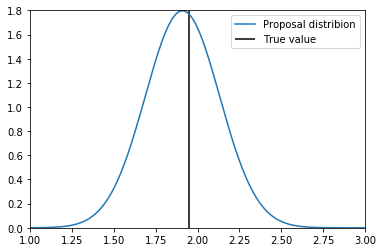

In [7]:
x = np.linspace(1,3,400)
y = norm.pdf(x,mu_val,np.exp(lg_sigma_val))

plt.plot(x,y,label="Proposal distribion")
plt.vlines(np.log(7),0,y.max(), label="True value")
plt.legend()

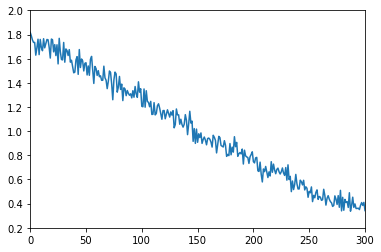

In [8]:
plt.plot(em_v)

In [9]:
np.sum(em_v<0)

0